<a href="https://colab.research.google.com/github/daniel-falk/ai-ml-principles-exercises/blob/main/ML-training/activeloop-deeplake/deeplake_imagenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Working with massive datasets
This notebooks serves as an example to how easy it is to work with massive datasets when using DeepLake. The ImageNet training dataset is approximately 1TB in size. Since the DeepLake dataset only holds the metadata and fetches the images as they are needed, there is no need for massive amount of RAM or diskspace to store the dataset locally.

In [1]:
!pip install deeplake
!pip install hurry.filesize

import deeplake
import numpy as np
from hurry.filesize import size
from IPython.display import clear_output

clear_output()

In [2]:
ds = deeplake.load('hub://activeloop/imagenet-train', token="REPLACE_ME")

hub://activeloop/imagenet-train loaded successfully.
This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/imagenet-train


In [3]:
print(f"Dataset has {len(ds)} images")

Dataset has 1281166 images


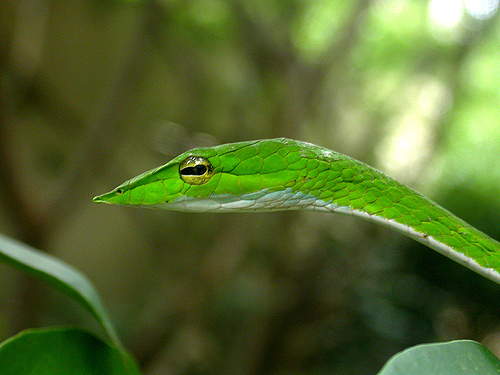

In [4]:
# Show an arbitrary image from the dataset
from PIL import Image
Image.fromarray(ds.images[12345].numpy())

## Iterate the full dataset to do an aggregation
The following code will iterate over every image in the dataset (about 1 million images), download the image and calculate the mean value of each color channel. This information is then aggregated from all the images in the dataset to give the final channel means for the full dataset.

In [5]:
# This function will be called for each image in the dataset
@deeplake.compute
def calculate_mean(sample_in, sample_out, skipped_images):
  img = sample_in.images.numpy()
  if len(img.shape) < 3 or img.shape[2] < 3:
    skipped_images.append(sample_in.index.values[0].value)
    return None
  sample_out.means.append(img.mean(axis=(0,1)))
  return sample_out

In [6]:
from time import time

skipped_list = []
t0 = time()

skipped_images = []
tmp_ds = deeplake.empty("mem://tmp_ds")
tmp_ds.create_tensor("means", htype="generic")
calculate_mean(skipped_images).eval(ds, tmp_ds, num_workers=16)
final_mean = tmp_ds.means.numpy().mean(axis=0)

duration = time() - t0

print()
print(f"Skipped {len(skipped_images)} gray-scale images")
print(f"In total it took {duration:.0f} seconds, visited in average {len(tmp_ds) / duration:.1f} images per second")
print(f"All done! Mean is {final_mean / 255}")

Evaluating calculate_mean:  51%|█████▏    | 659765/1281166 [2:18:17<2:26:09, 70.86it/s]/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
Evaluating calculate_mean: 100%|██████████| 1281166/1281166 [4:28:46<00:00, 79.45it/s]



Skipped 19970 gray-scale images
In total it took 16131 seconds, visited in average 78.2 images per second
All done! Mean is [0.48170302 0.45769877 0.40729597]
